# Linear LLM-innovator evolution chain

This notebook showcases a simple example run of linear evolution with a LLM-innovator on the kernel density estimation (KDE) challenge problem. 


### Table of contents
1. [Load linear evolution chains](#load)
2. [Visualise KDE instances](#visualise)

In [2]:
import json
import time

import numpy as np

import matplotlib.pyplot as plt


import autoinnovator

In [8]:
path_to_challenges = '../../challenges/'

<a id="load"></a>
## 1. Load linear evolution chains

In [35]:
# run parameters
exp_name = 'KDE'
config_name = 'testGPT4o2D'
seed = 3
max_prompt_iters = 8
LLM_prompt_time_ms = 1749055212305

In [36]:
# load config symbols
challenge_dir = path_to_challenges + exp_name + '/'
config_file = challenge_dir + f'config_{config_name}.py'
LLM_temperature, LLM_name, challenge_params = autoinnovator.utils.import_model_specific_symbols(
    config_file, ['LLM_temperature', 'LLM_name', 'challenge_params'])


# experiment name
folder_name = f'seed{seed}iters{max_prompt_iters}time{LLM_prompt_time_ms}'
run_results_path = f'{config_name}/{folder_name}/'

In [37]:
with open(run_results_path + "reasoning.json", "r") as f:
   reasontext_dict = json.load(f)

with open(run_results_path + "evaluation_feedback.json", "r") as f:
   feedback_prompt_dict = json.load(f)

In [38]:
print(reasontext_dict['2'])


In this iteration, I replaced Silverman's rule with a more adaptive bandwidth selection mechanism that scales by the total range of the data (using `.ptp()` method). This method accounts for the dispersion of data points across dimensions for non-Gaussian distributions.

I also adjusted the exponent in the bandwidth calculation from `-1/5` to `-1/6`. This aims to reduce excessive kernel overlap in higher-dimensional spaces while attempting to improve density accuracy.

The factor `0.9` added to the bandwidth formula is more conservative than Silverman's `1.06`, as I suspect the original value may have led to overly similar Gaussians, which could suppress diversity in the kernel density model. These changes should improve the likelihood scores without drastically increasing runtime or complexity.

Key notes from the previous evaluation:
- The test likelihood score was low (-0.024), indicating the algorithm's poor generalization.
- Code complexity was relatively small and should be kept

In [39]:
import ast

test_log_likelihood_averages, elapsed_time_seconds = [], []
for i in range(1, max_prompt_iters + 1):
    if feedback_prompt_dict[str(i)][0] != '{':  # error
        test_log_likelihood_averages.append(np.nan)
        elapsed_time_seconds.append(np.nan)
        continue

    safe_dict = ast.literal_eval(feedback_prompt_dict[str(i)])

    test_log_likelihood_averages.append(safe_dict['test_log_likelihood_average'])
    elapsed_time_seconds.append(safe_dict['elapsed_time_seconds'])

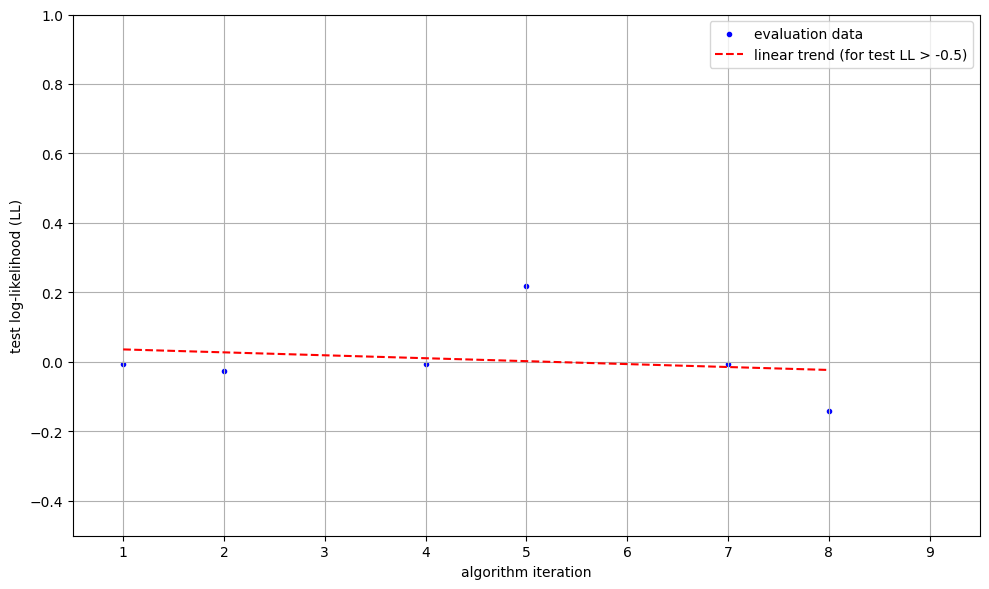

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress


# Your data
y = np.array(test_log_likelihood_averages)
x = np.arange(len(y))

sel_inds = np.where(y > -0.5)[0]
y_ = y[sel_inds]
x_ = x[sel_inds]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_, y_)
y_pred = slope * x + intercept


# Plot everything
plt.figure(figsize=(10, 6))
plt.scatter(1 + x, y, label="evaluation data", color='blue', marker='.')
plt.plot(1 + x, y_pred, label="linear trend (for test LL > -0.5)", linestyle='--', color='red')
plt.ylim(-0.5, 1)
plt.xlim(0.5, len(x) + 1.5)
plt.xlabel("algorithm iteration")
plt.ylabel("test log-likelihood (LL)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

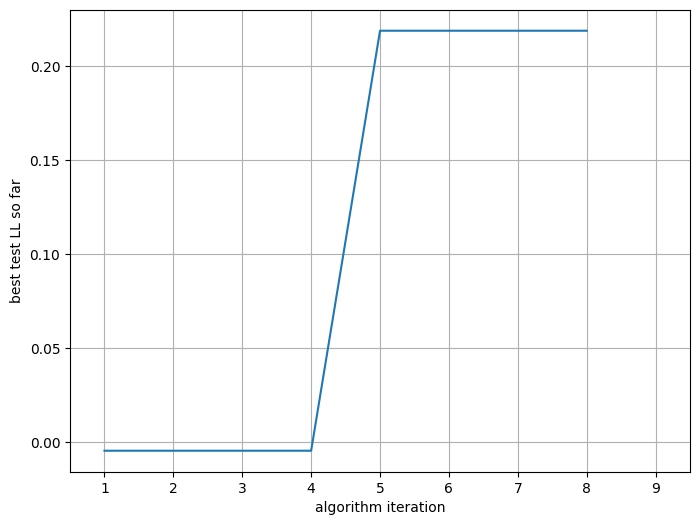

In [41]:
rolling_max = [np.nan_to_num(test_log_likelihood_averages, nan=-np.inf)[:i + 1].max() for i in range(max_prompt_iters)]

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_prompt_iters + 1), rolling_max)
plt.grid('on')
plt.xlabel("algorithm iteration")
plt.ylabel('best test LL so far')
plt.xlim(0.5, max_prompt_iters + 1.5)
plt.show()

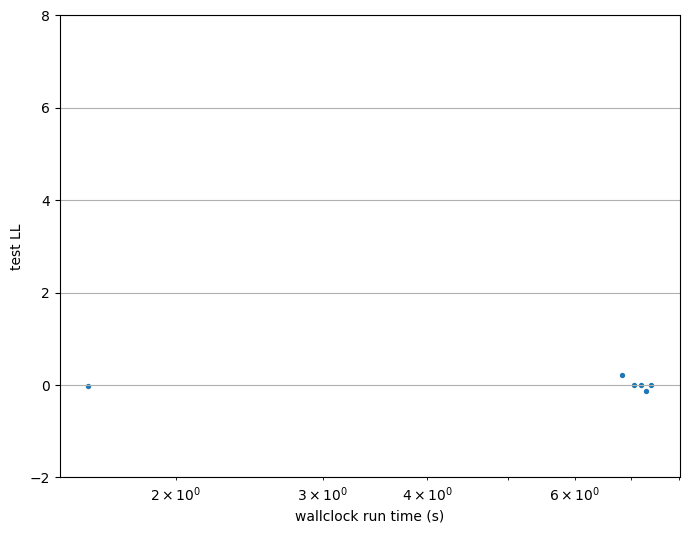

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(elapsed_time_seconds, test_log_likelihood_averages, s=8)
plt.xscale('log')
plt.xlabel('wallclock run time (s)')
plt.ylabel('test LL')
plt.ylim(-2, 8)
plt.grid('on')

<a id="visualise"></a>
## 2. Visualise KDE instances

In [47]:
dims = challenge_params['dims']
algo_id = 4  # select algo ID to run and visualise in notebook
template_script_file = challenge_dir + 'template.py'
algo_script_file = run_results_path + f'algo{algo_id}.py'


generate_samples, log_prob_multivariate_Gaussian_mixture = autoinnovator.utils.import_model_specific_symbols(
    template_script_file, ['generate_samples', 'log_prob_multivariate_Gaussian_mixture'])

# generate instance
algorithm_func, = autoinnovator.utils.import_model_specific_symbols(algo_script_file, ['algorithm_func'])

# evaluation
show_num_instances = 8  # max 64
start_time = time.time()

grid_pts = 128


plot_data = []
for i in range(show_num_instances):
    print(f'{i + 1} / {show_num_instances}')

    instances_seed = seed + i

    rng_samps = np.random.default_rng(instances_seed + 1)

    num_samples = challenge_params['num_train_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(instances_seed)
    train_xs = generate_samples(rng_params, z)

    num_samples = challenge_params['num_test_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(instances_seed)
    test_xs = generate_samples(rng_params, z)

    weight_logits, mus, covs = algorithm_func(train_xs)
    ws_logits_batch, mus_batch, covs_batch = weight_logits[None], mus[None], covs[None]

    # evaluate GMM log prob
    x = np.linspace(train_xs[:, 0].min() - 0.5, train_xs[:, 0].max() + 0.5, grid_pts)
    y = np.linspace(train_xs[:, 1].min() - 0.5, train_xs[:, 1].max() + 0.5, grid_pts)
    X, Y = np.meshgrid(x, y)
    xy = np.stack([X, Y], axis=-1).reshape(-1, 2)  # (num_pts, 2)
    log_prob_xy = log_prob_multivariate_Gaussian_mixture(xy, ws_logits_batch, mus_batch, covs_batch)


    plot_data.append(
        [train_xs, test_xs, X, Y, log_prob_xy.reshape(grid_pts, grid_pts)]
    )


loop_elapsed_time = time.time() - start_time
print(f"Completed loop in {loop_elapsed_time:.2f} seconds...")

1 / 8
2 / 8
3 / 8
4 / 8
5 / 8
6 / 8
7 / 8
8 / 8
Completed loop in 20.20 seconds...


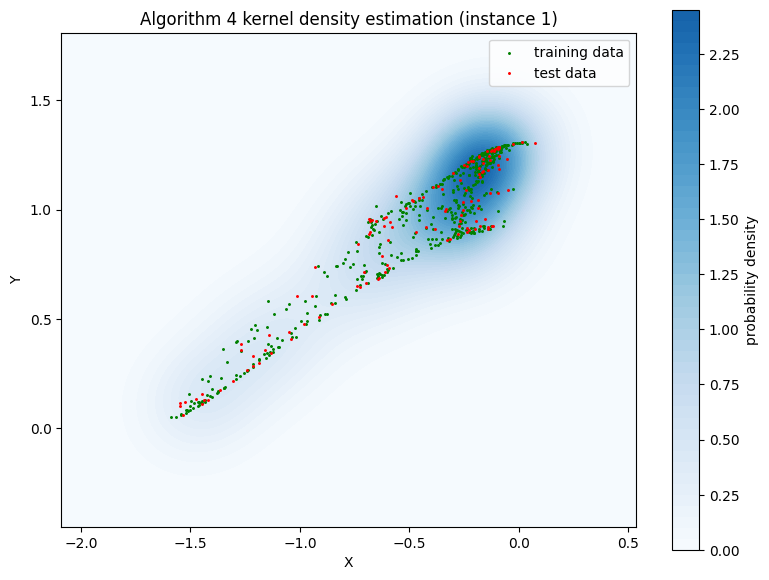

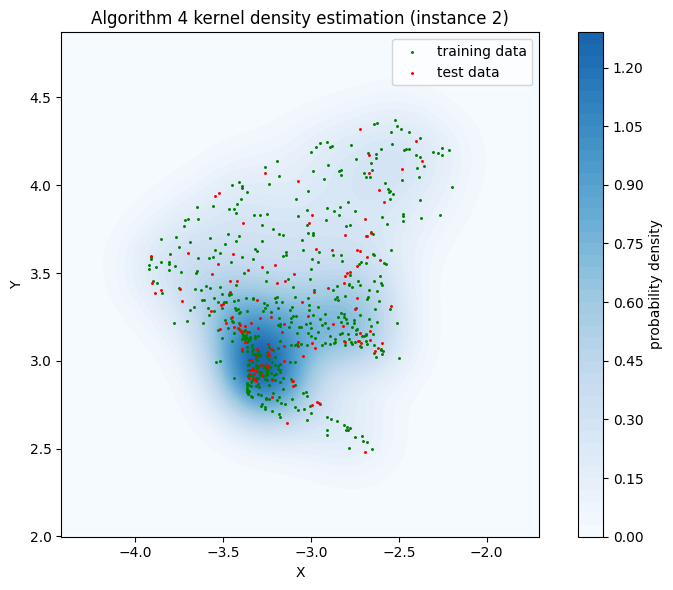

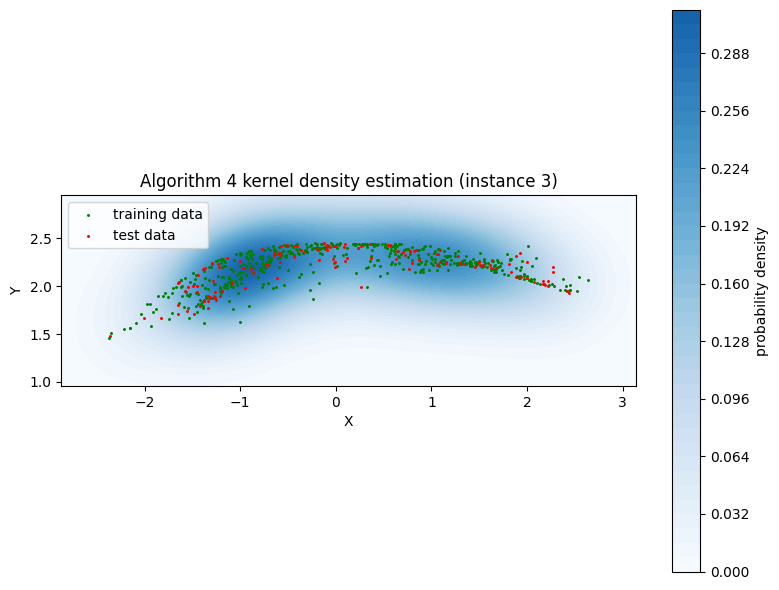

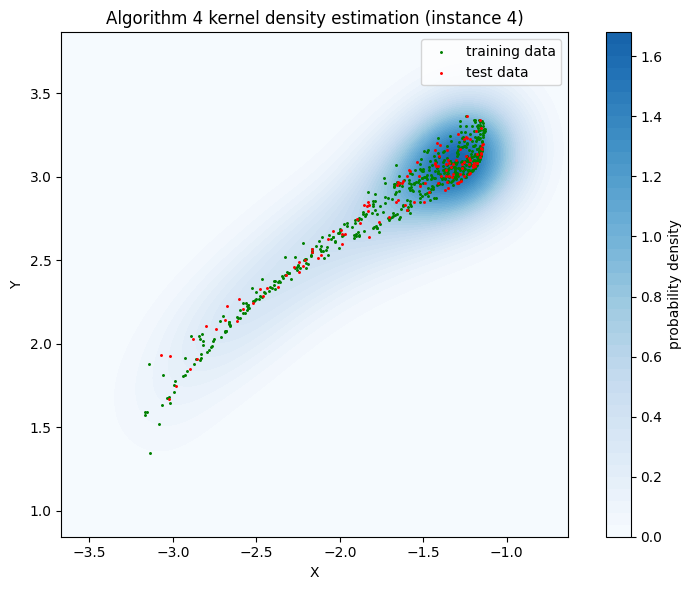

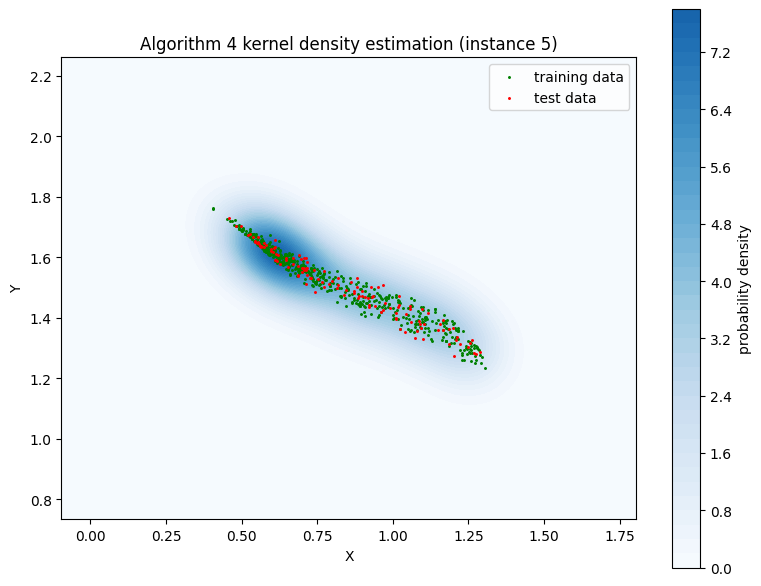

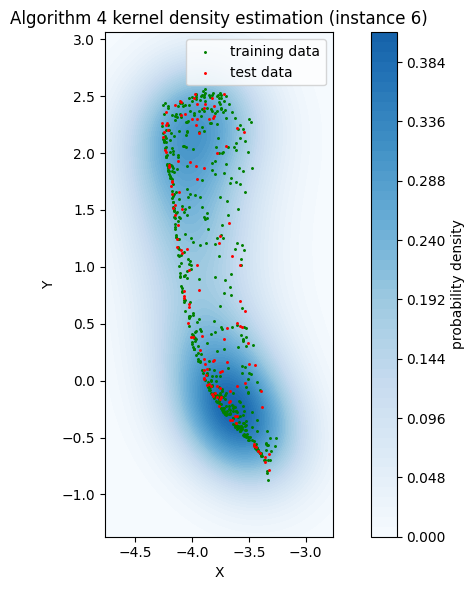

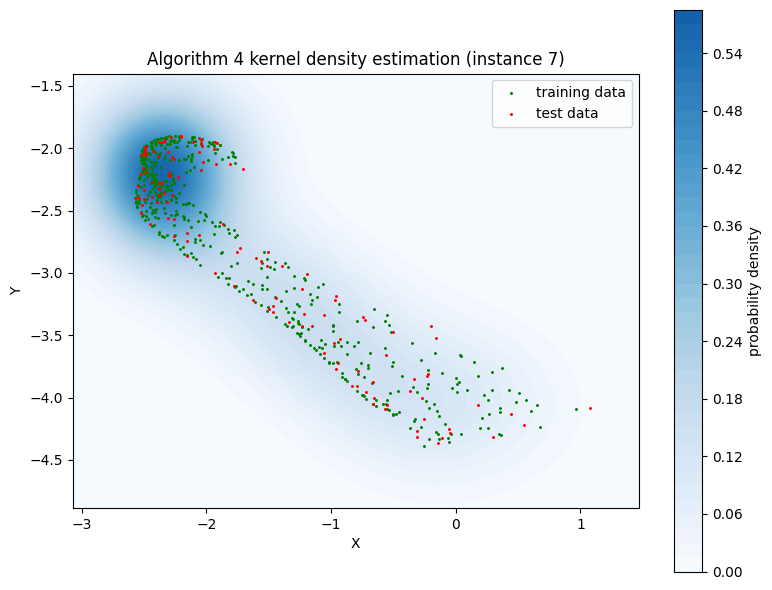

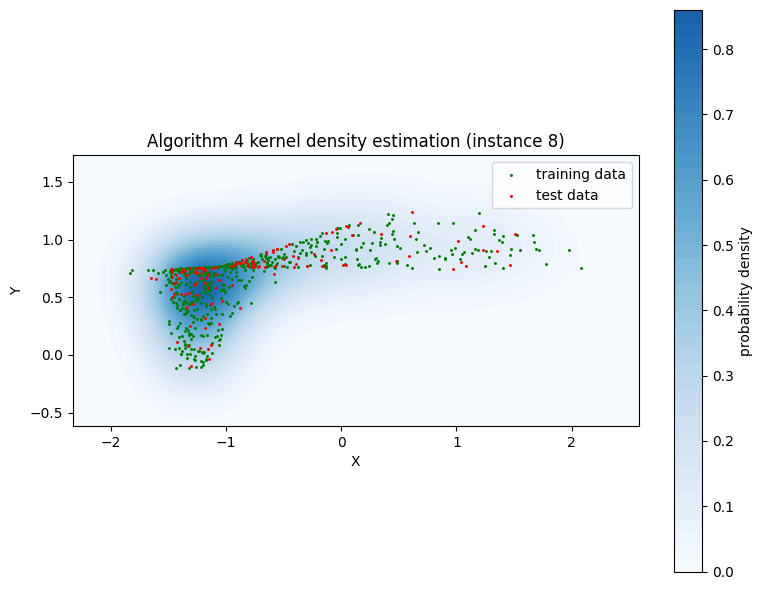

In [48]:
for ind in range(show_num_instances):

    train_xs, test_xs, X, Y, log_prob_xy = plot_data[ind]
    P = np.exp(log_prob_xy)

    plt.figure(figsize=(8, 6))

    plt.contourf(X, Y, P, vmax=P.max() * 1.25, levels=50, cmap="Blues")
    plt.colorbar(label="probability density")

    plt.scatter(train_xs[:, 0], train_xs[:, 1], marker='.', s=5, c='green', label='training data')
    plt.scatter(test_xs[:, 0], test_xs[:, 1], marker='.', s=5, c='red', label='test data')

    plt.title(f"Algorithm {algo_id} kernel density estimation (instance {ind + 1})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal')

    plt.legend()
    plt.tight_layout()
    plt.show()